# 1 - Packages
First, let's run the cell below to import all the packages that you will need during this assignment.

numpy is the fundamental package for scientific computing with Python.
matplotlib is a famous library to plot graphs in Python.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import math
from google.colab import drive
import matplotlib.image as mpimg 
drive.mount('/content/drive')
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
def load_data(filename):
    data = np.loadtxt(filename, delimiter=',')
    X = data[:,:2]
    y = data[:,2]
    return X, y


2 - Logistic Regression
In this part of the exercise, we will build a logistic regression model to predict whether a student gets admitted into a university.


**2.1 Problem Statement**
Suppose that we are the administrator of a university department and we want to determine each applicant’s chance of admission based on their results on two exams.

We have historical data from previous applicants that we can use as a training set for logistic regression.
For each training example, we have the applicant’s scores on two exams and the admissions decision.
Our task is to build a classification model that estimates an applicant’s probability of admission based on the scores from those two exams.

**2.2 Loading and visualizing the data**
We will start by loading the dataset for this task.

The load_dataset() function shown below loads the data into variables X_train and y_train
X_train contains exam scores on two exams for a student
y_train is the admission decision
y_train = 1 if the student was admitted
y_train = 0 if the student was not admitted
Both X_train and y_train are numpy arrays.

In [29]:
# load dataset
path_testing = "/content/drive/MyDrive/Code/A-logistic-regression-model-predicting-a student's-admission-to-a-uni/ex2data1.txt"
X_train, y_train = load_data(path_testing)

**View the variables**
Let's get more familiar with our dataset.

A good place to start is to just print out each variable and see what it contains.
The code below prints the first five values of X_train and the type of the variable

In [30]:
print("First five elements in X_train are:\n", X_train[:5])
print("Type of X_train:",type(X_train))

First five elements in X_train are:
 [[34.62365962 78.02469282]
 [30.28671077 43.89499752]
 [35.84740877 72.90219803]
 [60.18259939 86.3085521 ]
 [79.03273605 75.34437644]]
Type of X_train: <class 'numpy.ndarray'>


Now print the first five values of y_train

In [31]:
print("First five elements in y_train are:\n", y_train[:5])
print("Type of y_train:",type(y_train))

First five elements in y_train are:
 [0. 0. 0. 1. 1.]
Type of y_train: <class 'numpy.ndarray'>


**Checking the dimensions of our variables**

Another useful way to get familiar with data is to view its dimensions. Let's print the shape of X_train and y_train and see how many training examples we have in our dataset.

In [32]:
print ('The shape of X_train is: ' + str(X_train.shape))
print ('The shape of y_train is: ' + str(y_train.shape))
print ('We have m = %d training examples' % (len(y_train)))

The shape of X_train is: (100, 2)
The shape of y_train is: (100,)
We have m = 100 training examples


# Visualizing data

Before starting to implement any learning algorithm, it is always good to visualize the data if possible.

In [33]:
def plot_data(X, y, pos_label="y=1", neg_label="y=0"):
    positive = y == 1
    negative = y == 0
    
    # Plot examples
    plt.plot(X[positive, 0], X[positive, 1], 'k+', label=pos_label)
    plt.plot(X[negative, 0], X[negative, 1], 'yo', label=neg_label)

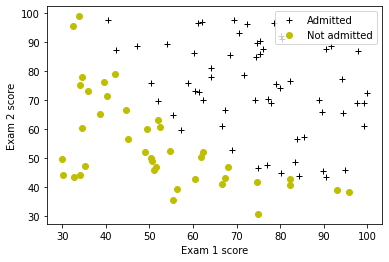

In [34]:
# Plot examples
plot_data(X_train, y_train[:], pos_label="Admitted", neg_label="Not admitted")

# Set the y-axis label
plt.ylabel('Exam 2 score') 
# Set the x-axis label
plt.xlabel('Exam 1 score') 
plt.legend(loc="upper right")
plt.show()

Our goal is to build a logistic regression model to fit this data. 

*   With this model, you can then predict if a new student will be admitted  based on their scores on the two exams.




# ** Sigmoid function**

Recall that for logistic regression, the model is represented as

𝑓𝐰,𝑏(𝑥)=𝑔(𝐰⋅𝐱+𝑏)
 
where function  𝑔  is the sigmoid function. The sigmoid function is defined as:

𝑔(𝑧)=11+𝑒−𝑧
 
Let's implement the sigmoid function first, so it can be used by the rest of this assignment.


Exercise 1 **bold text**
Please complete the sigmoid function to calculate

𝑔(𝑧)=11+𝑒−𝑧
 
Note that

z is not always a single number, but can also be an array of numbers.
If the input is an array of numbers, we'd like to apply the sigmoid function to each value in the input array.

In [35]:
def sigmoid(z):
   g = 1/(1+np.exp(-z))
   return g

**Cost function for logistic regression**

Recall that for logistic regression, the cost function is of the form 

$$ J(\mathbf{w},b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) \right] \tag{1}$$

where
* m is the number of training examples in the dataset


* $loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)})$ is the cost for a single data point, which is - 

    $$loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) = (-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \tag{2}$$
    
    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$, which is the actual label

*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(\mathbf{w} \cdot \mathbf{x^{(i)}} + b)$ where function $g$ is the sigmoid function.
* It might be helpful to first calculate an intermediate variable $z_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x^{(i)}} + b = w_0x^{(i)}_0 + ... + w_{n-1}x^{(i)}_{n-1} + b$ where $n$ is the number of features, before calculating $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(z_{\mathbf{w},b}(\mathbf{x}^{(i)}))$

Note:
The variables X_train and y_train are not scalar values but matrices of shape ( 𝑚,𝑛 ) and ( 𝑚 ,1) respectively, where  𝑛  is the number of features and  𝑚  is the number of training examples.

In [36]:
def compute_cost(X, y, w, b, lambda_= 1):

    m, n = X.shape
    
    cost = 0.0
    for i in range(m):
        z_i = np.dot(X[i],w) + b
        f_wb_i = sigmoid(z_i)
        cost += -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)
    total_cost = cost/m
    
    return total_cost

In [37]:
m, n = X_train.shape

# Compute and display cost with w initialized to zeroes
initial_w = np.zeros(n)
initial_b = 0.
cost = compute_cost(X_train, y_train, initial_w, initial_b)
print('Cost at initial w (zeros): {:.3f}'.format(cost))

Cost at initial w (zeros): 0.693


<a name="2.5"></a>
### 2.5 Gradient for logistic regression

Recall that the gradient descent algorithm is:

$$\begin{align*}& \text{repeat until convergence:} \; \lbrace \newline \; & b := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \newline       \; & w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j := 0..n-1}\newline & \rbrace\end{align*}$$

where, parameters $b$, $w_j$ are all updated simultaniously

<a name='ex-03'></a>

$$
\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)}) \tag{2}
$$
$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})x_{j}^{(i)} \tag{3}
$$
* m is the number of training examples in the dataset

    
*  $f_{\mathbf{w},b}(x^{(i)})$ is the model's prediction, while $y^{(i)}$ is the actual label


- **Note**: While this gradient looks identical to the linear regression gradient, the formula is actually different because linear and logistic regression have different definitions of $f_{\mathbf{w},b}(x)$.


In [38]:
def compute_gradient(X, y, w, b, lambda_=None): 

    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)
        err_i = f_wb_i - y[i]
        for j in range(n): 
            dj_dw[j] += err_i*X[i,j]
        
        dj_db += err_i
        
    dj_dw = dj_dw/m
    dj_db = dj_db/m
        
    return dj_db, dj_dw

In [39]:
# Compute and display gradient with w initialized to zeroes
initial_w = np.zeros(n)
initial_b = 0.

dj_db, dj_dw = compute_gradient(X_train, y_train, initial_w, initial_b)
print(f'dj_db at initial w (zeros):{dj_db}' )
print(f'dj_dw at initial w (zeros):{dj_dw.tolist()}' )

dj_db at initial w (zeros):-0.1
dj_dw at initial w (zeros):[-12.00921658929115, -11.262842205513591]


**Learning parameters using gradient descent**

We will now find the optimal parameters of a logistic regression model by using gradient descent. 

- A good way to verify that gradient descent is working correctly is to look
at the value of $J(\mathbf{w},b)$ and check that it is decreasing with each step. 

- Assuming you have implemented the gradient and computed the cost correctly, our value of $J(\mathbf{w},b)$ should never increase, and should converge to a steady value by the end of the algorithm.

In [40]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 
    
    # number of training examples
    m = len(X)
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # Calculating the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   

        # Updating Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
       
        # Saving cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Printing cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

In [41]:
np.random.seed(1)
intial_w = 0.01 * (np.random.rand(2).reshape(-1,1) - 0.5)
initial_b = -8


# Some gradient descent settings
iterations = 10000
alpha = 0.001

w,b, J_history,_ = gradient_descent(X_train ,y_train, initial_w, initial_b, 
                                   compute_cost, compute_gradient, alpha, iterations, 0)

Iteration    0: Cost     1.01   
Iteration 1000: Cost     0.31   
Iteration 2000: Cost     0.30   
Iteration 3000: Cost     0.30   
Iteration 4000: Cost     0.30   
Iteration 5000: Cost     0.30   
Iteration 6000: Cost     0.30   
Iteration 7000: Cost     0.30   
Iteration 8000: Cost     0.30   
Iteration 9000: Cost     0.30   
Iteration 9999: Cost     0.30   


# **Evaluating logistic regression**
We can evaluate the quality of the parameters we have found by seeing how well the learned model predicts on our training set.

We will implement the predict function below to do this.

- First we need to compute the prediction from the model $f(x^{(i)}) = g(w \cdot x^{(i)})$ for every example 
    - We've implemented this before in the parts above
- We interpret the output of the model ($f(x^{(i)})$) as the probability that $y^{(i)}=1$ given $x^{(i)}$ and parameterized by $w$.
- Therefore, to get a final prediction ($y^{(i)}=0$ or $y^{(i)}=1$) from the logistic regression model, we can use the following -

  if $f(x^{(i)}) >= 0.5$, predict $y^{(i)}=1$
  
  if $f(x^{(i)}) < 0.5$, predict $y^{(i)}=0$

In [42]:
def predict(X, w, b): 
    
    # number of training examples
    m, n = X.shape   
    p = np.zeros(m)
    
    # Looping over each example
    for i in range(m):   
        z_wb = 0
        # Looping over each feature
        for j in range(n): 
            # Add the corresponding term to z_wb
            z_wb_ij = X[i, j] * w[j]
            z_wb += z_wb_ij
        
        # Adding bias term 
        z_wb += b
        
        # Calculating the prediction for this example
        f_wb = sigmoid(z_wb)

        # Applying the threshold
        if f_wb >= 0.5:
            p[i] = 1
        else:
            p[i] = 0
        
    return p

**Now let's use this to compute the accuracy on the training set**

In [43]:
#Compute accuracy on our training set
p = predict(X_train, w,b)
print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))

Train Accuracy: 92.000000
